In [11]:
import functools
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

(a) Plot the graph with given code, the result should be same as this.
![](originalData.png)
`x_train` and `y_train` are the datas you need to create, `sample_size` is 10 and `std` is 0.25. 

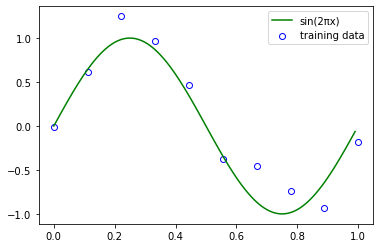

In [13]:
# Write you codes here.
x = np.arange(0, 1, 0.01)
y = func(x)
plt.plot(x, y, 'g-')
plt.scatter(x_train, y_train, marker='o', c='w', edgecolors='b')
plt.legend(labels = ('sin(2πx)', 'training data'), loc = 'upper right')

(b) On the basis of the results, you should try $0^{th}$ order polynomial, $1^{st}$ order polynomial, $3^{rd}$ order polynomial and some other order polynomial, show the results include fitting and over-fitting.
![](fitting.png)

In [14]:
class PolynomialFeature(object):
    """
    polynomial features

    transforms input array with polynomial features

    Example
    =======
    x =
    [[a, b],
    [c, d]]

    y = PolynomialFeatures(degree=2).transform(x)
    y =
    [[1, a, b, a^2, a * b, b^2],
    [1, c, d, c^2, c * d, d^2]]
    """

    def __init__(self, degree=2):
        """
        construct polynomial features

        Parameters
        ----------
        degree : int
            degree of polynomial
        """
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        """
        transforms input array with polynomial features

        Parameters
        ----------
        x : (sample_size, n) ndarray
            input array

        Returns
        -------
        output : (sample_size, 1 + nC1 + ... + nCd) ndarray
            polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()
    
class Regression(object):
    """
    Base class for regressors
    """
    pass
    
class LinearRegression(Regression):
    """
    Linear regression model
    y = X @ w
    t ~ N(t|X @ w, var)
    """

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        """
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X:np.ndarray, return_std:bool=False):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            samples to predict their output
        return_std : bool, optional
            returns standard deviation of each predition if True

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        y_std : (N,) np.ndarray
            standard deviation of each predition
        """
        y = X @ self.w
        if return_std:
            y_std = np.sqrt(self.var) + np.zeros_like(y)
            return y, y_std
        return y

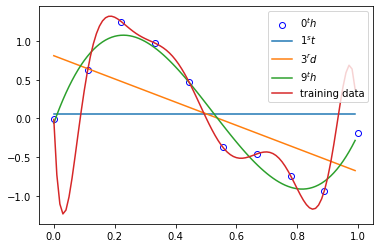

In [15]:
# Write your codes here.

orders = [0, 1, 3, 9]

plt.scatter(x_train, y_train, marker='o', c='w', edgecolors='b')
reg = LinearRegression()
training_data_x = []
testing_data_x = []
training_data_y = []
testing_data_y = []

for order in orders:
    p = PolynomialFeature(order)
    x_train_order = p.transform(x_train)
    x_order = p.transform(x)

    reg.fit(x_train_order, y_train)
    y_predict = reg.predict(x_order)
    plt.plot(x, y_predict)

    training_data_x.append(x_train_order)
    training_data_y.append(reg.predict(x_train_order))
    x_test_order = p.transform(x_test)
    testing_data_x.append(x_test_order)
    testing_data_y.append(reg.predict(x_test_order))
plt.legend(['$0^th$', '$1^st$', '$3^rd$', '$9^th$', 'training data'])

(c) Plot the graph of the root-mean-square error.

In [16]:
def rmse(a, b):
        return np.sqrt(np.mean(np.square(a-b)))

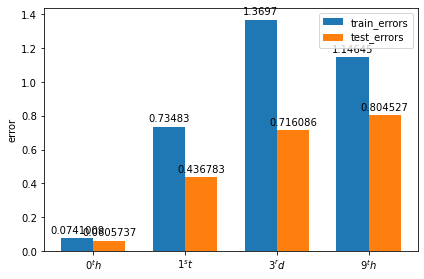

In [17]:
# Write your codes here.

training_errors = [rmse(a, b) for (a, b) in zip(y_train, training_data_y)]
test_errors = [rmse(a, b) for (a, b) in zip(y_test, testing_data_y)]

labels = ['$0^th$', '$1^st$', '$3^rd$', '$9^th$']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_errors, width, label='train_errors')
rects2 = ax.bar(x + width/2, test_errors, width, label='test_errors')

ax.set_ylabel('error')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

(d) Plot the graph of the predictive distribution resulting from a Bayesian treatment of polynomial curve fitting using an M=9 polynomial, with the fixed parameters $\alpha=5\times 10^{-3}$ and $\beta=11.1$(corresponding to the known noise variance).
![](bayesianRegression.png)

In [8]:
class BayesianRegression(Regression):
    """
    Bayesian regression model

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y

In [9]:
# Write your codes here.
model = BayesianRegression(0.005, 11.1)
model.fit(training_data_x[-1], y_train)
predict = model.predict(testing_data_x[-1], sample_size=10)
print(predict)

[[ 0.03293339  0.29251904  0.34213104 -0.00633306 -0.35544873 -0.00900254
   0.14632815  0.16381393 -0.13813836 -0.20928567]
 [ 0.09862566  0.31397808  0.36028638  0.06866807 -0.2605495   0.04970471
   0.22446183  0.20502549 -0.06018164 -0.16042669]
 [ 0.1611809   0.33533208  0.37989478  0.14199965 -0.16882834  0.10481949
   0.29983298  0.24457873  0.01593041 -0.11155184]
 [ 0.22062337  0.35653113  0.40078766  0.21353548 -0.08032368  0.15638205
   0.37239174  0.2824793   0.09008173 -0.06277198]
 [ 0.27697667  0.37752418  0.42279587  0.28314888  0.00492598  0.20443513
   0.4420898   0.31873384  0.16215658 -0.01419863]
 [ 0.33026379  0.39825898  0.44574997  0.35071298  0.0868822   0.24902404
   0.50888042  0.35334965  0.2320397   0.03405596]
 [ 0.38050709  0.41868209  0.46948048  0.41610103  0.16550671  0.29019668
   0.57271851  0.38633441  0.2996165   0.08187894]
 [ 0.42772839  0.43873885  0.49381817  0.47918668  0.24076151  0.32800359
   0.63356079  0.41769579  0.36477325  0.12915684]


(e) Change the $sample\_size$ to 2, 3 or 10 times than before, explain the change of $M$.

In [10]:
# Write your codes here.
